This notebook performs the following steps:

- Imports necessary libraries for data manipulation, visualization, and machine learning.
- Defines utility functions to load change events from a JSON file, extract a variety of features into a DataFrame, and plot clusters.
- Loads change events, extracts features, and removes incomplete data.
- Standardizes the features and uses UMAP to reduce dimensionality for clustering and visualization.
- Applies Gaussian Mixture Model clustering to assign cluster labels.
- Updates the original events with the new cluster labels and saves the results to a new JSON file.

In [1]:
# Install missing packages if required: UMAP with pip install umap-learn in notebook

!python -m pip install umap-learn scikit-learn pandas matplotlib
from aimon.helpers.classification import map_label_to_unlabelled_collection, save_events_to_json, plot_umap_clusters,load_and_prepare_data_for_UMAP
from aimon import ProjectChange
import os
from sklearn.mixture import GaussianMixture
import umap.umap_ as umap  # UMAP for dimensionality reduction

# Set current directory to the location of the notebook (works even if __file__ is not defined)
try:
    current_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    current_dir = os.getcwd()

os.chdir(current_dir)

### Relevant parameters

In [2]:
# Path to the unlabelled change events test file
change_events_file = "../test_data/change_events_unlabelled.json"
outfolder = "../test_data/out"


random_state=42
# Parameter for UMAP 
n_neighbors=50
min_dist=0.1
n_components_umap=2
metric = "manhattan" 

# Parameter for clustering
n_components_GMM=3

os.makedirs(outfolder, exist_ok=True)
# Path to the labelled change events file
change_events_file_labelled = "../test_data/change_events_labelled_using_umap_and_gmm.json"

### Load unlabelled change events and reduce the dimensionality of the feature set using UMAP

In [3]:
features_df_without_id, features_df, X_scaled, unlabelled_coll = load_and_prepare_data_for_UMAP(change_events_file)

# UMAP for enhanced clustering
reducer = umap.UMAP(n_neighbors=n_neighbors,
                    min_dist=min_dist,
                    n_components=n_components_umap, 
                    random_state=random_state,
                    metric=metric)
# Fit UMAP to the scaled data
# Note: X_scaled is the scaled data, which is used for UMAP fitting and transformation
X_umap = reducer.fit_transform(X_scaled)

### Gaussian Mixture Model Clustering

In [4]:
# Clustering using Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=n_components_GMM, random_state=random_state)
labels = gmm.fit_predict(X_umap)
# Overwrite the labels in the features_df
features_df['event_type'] = labels

### Plot UMAP clusters

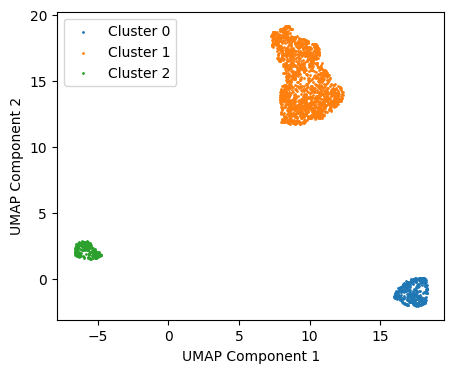

In [5]:
# Plot UMAP clusters
plot_umap_clusters(X_umap, labels)

### Save clustered change events

In [6]:
unlabelled_coll = map_label_to_unlabelled_collection(unlabelled_coll, features_df)
save_events_to_json(unlabelled_coll, change_events_file_labelled)

# Save to .geojson for visual inspection

In [9]:
change_prj = ProjectChange(change_event_file = change_events_file_labelled,
                           project_name = os.path.basename(change_events_file_labelled)[:-4],
                           projected_image_folder = "",
                           projected_events_folder = outfolder)
change_prj.project_change()

Missing some information, cannot find 
Missing some information, cannot project change into image
